In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import IPython.display as ipd
import librosa
import soundfile as sf

import tensorflow as tf

tf.random.set_seed(999)
np.random.seed(999)

2023-05-24 05:21:01.754490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 05:21:01.844873: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 05:21:01.846241: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 05:21:03.951760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATA_PATH = '/run/media/svyatoslav/Files/Documents/speech/data'

SPEECH_DATASET = f'{DATA_PATH}/input/speech/'

CLEAN_TRAIN = f'{DATA_PATH}/input/clean_train/'

CLEAN_TEST = f'{DATA_PATH}/input/clean_test/'

NOISE_TRAIN = f'{DATA_PATH}/input/noise/'

NOISE_TEST = f'{DATA_PATH}/input/noise_test/'

SAMPLE_RATE = 16000

WINDOW_LENGTH = 512

OVERLAP = round(0.5 * WINDOW_LENGTH) # 50%

N_FFT = WINDOW_LENGTH

N_FEATURES = N_FFT // 2 + 1 # 257

N_SEGMENTS = 1

In [3]:
# tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
model = tf.keras.models.load_model('/home/svyatoslav/ml/speech_denosing/src/crnn_denoising/models/speech_model.h5')

2023-05-24 05:21:06.737618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-24 05:21:06.738461: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
class FeatureExtractor:

    def start_preprocess(self, audio):
        """
        This function takes in an audio file and extracts features from it using other functions.
        :param audio: path to audio file
        :return: numpy array
        """
        spectrogram = self._make_spectrograms(audio)
        self.show_spectrogram(spectrogram, "Noisy")
        spectrogram = self._calculate_means(spectrogram)

        X = self._reshape_predictors(self._prepare_input_features(spectrogram))
        x_predictor = np.asarray(X)
        return x_predictor


    def show_spectrogram(self, spectrogram, title):
        result = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max).astype(np.float32)
        plt.figure(figsize=(10,4))
        plt.imshow(result)
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()


    def _make_spectrograms(self, audio_path, normalize=True):
        """
        This function takes in an audio file and generates spectrograms using the librosa library.
        :param audio_path: path to audio file
        :param normalize: whether or not to normalize the spectrograms
        :return: spectrogram
        """
        audio_np, _ = librosa.load(audio_path, sr=SAMPLE_RATE)
        if normalize:
            div_fac = 1 / np.max(np.abs(audio_np)) / 3.0
            audio_np = audio_np * div_fac
        return librosa.stft(y=audio_np, hop_length=OVERLAP, n_fft=N_FFT, center=True, window='hamming', win_length=WINDOW_LENGTH)


    def _calculate_means(self, spectrogram):
        '''
        Important step to avoid extreme differences (more than 45 degree) between the noisy and clean phase, and perform in-verse STFT and recover human speech later.
        :param spectrogram: audio spectrogram in numpy array
        :return: encoded spectrogram
        Taken from article 1609.07132
        '''
        self.audio_phase = np.angle(spectrogram)
        stft_feature = np.abs(spectrogram)
        mean = np.mean(stft_feature)
        std = np.std(stft_feature)
        self.mean = mean
        self.std = std
        return (stft_feature - mean) / std


    def _prepare_input_features(self, spectrogram):
        '''
        Feature extraction from STFT spectrograms.
        :param spectrogram: audio spectrogram in numpy array
        '''
        stft_feature = np.concatenate([spectrogram[:, 0:N_SEGMENTS-1], spectrogram], axis=1)
        stft_segments = np.zeros((N_FEATURES, N_SEGMENTS, stft_feature.shape[1] - N_SEGMENTS + 1))
        
        for index in range(stft_feature.shape[1] - N_SEGMENTS + 1):
            stft_segments[:, :, index] = stft_feature[:,index:index + N_SEGMENTS]
        
        return stft_segments


    def _reshape_predictors(self, items):
        '''
        Function to reshape features for NN
        :param items: numpy array - features
        :return: numpy array - prepared features [?, 257, 1, 1]
        '''
        predictors = np.reshape(items, (items.shape[0], items.shape[1], 1, items.shape[2]))
        predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
        return predictors

8/8 [==============================] - 1s 89ms/step


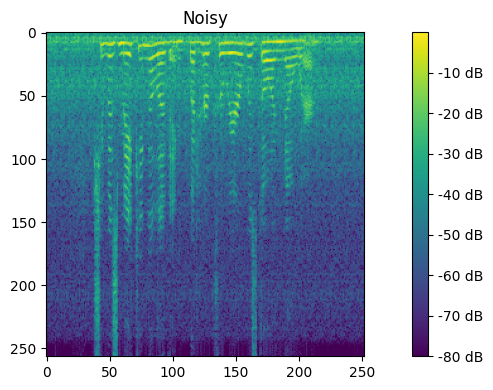

In [12]:
# Model testing
audio_files = glob(f'{DATA_PATH}/input/noisy_train/*.wav')

generator = FeatureExtractor()
x = generator.start_preprocess(audio_files[350])

result = model.predict(x)

In [13]:
class AudioRestorer:

    def revert_features_to_audio(self, features, phase, mean, std):
        """
        Function for scaling the outpus back to the original range
        :param features: outputs from neural network in numpy array
        :param phase: saved at first features preparation stage phase value
        :param mean: saved at first features preparation stage mean value
        :param std: saved at first features preparation stage std value
        :return: numpy array with restored audio
        """
        if mean and std:
            features = std * features + mean
            
        phase = np.transpose(phase, (1, 0))
        features = np.squeeze(features)
        
        features = features * np.exp(1j * phase)
        features = np.transpose(features, (1, 0))
        self.show_spectrogram(features, "Denoised")
        restored = self._restore_audio(features)
        
        return restored


    def _restore_audio(self, stft_features):
        """
        Function for restoring audio from stft spectrogram
        :param stft_features: outputs from neural network in numpy array
        :return: numpy array with restored audio
        """
        return librosa.istft(stft_features, win_length=WINDOW_LENGTH, hop_length=OVERLAP, window='hamming', center=True)


    def write_audio(self, denoised, filename):
        """
        Write audiofile
        :param denoised: numpy array with restored audio
        :param filename: str filename
        :return: path to file in str
        """
        path = f'audios/{filename}.wav'
        sf.write(path, denoised, SAMPLE_RATE)
        return path


    def show_spectrogram(self, spectrogram, title):
        result = librosa.amplitude_to_db(np.abs(spectrogram), ref=np.max).astype(np.float32)
        plt.figure(figsize=(10,4))
        plt.imshow(result)
        plt.colorbar(format='%+2.0f dB')
        plt.title(title)
        plt.tight_layout()

Min: -0.28607348 Max: 0.35167006


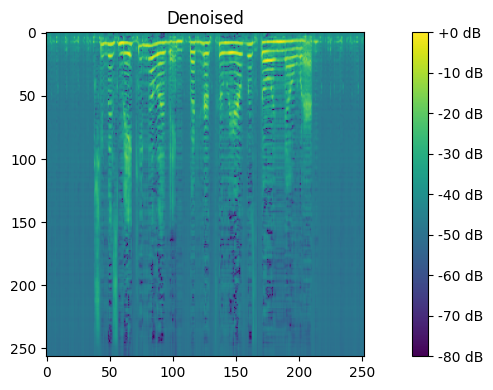

In [14]:
denoised = AudioRestorer().revert_features_to_audio(result, generator.audio_phase, generator.mean, generator.std)
print("Min:", np.min(denoised),"Max:",np.max(denoised))
ipd.Audio(data=denoised, rate=SAMPLE_RATE) # show wav file

In [15]:
# noisy_audio, sr = read_audio('noisy_file_example.wav', feature_sample)
# clean_audio, sr = read_audio('clean_file_example.wav', feature_sample)
# # denoised, sr = read_audio('denoised_file_example.wav', feature_sample)

# f, (ax1, ax2) = plt.subplots(2, 1, sharey=True)

# ax1.plot(clean_audio)
# ax1.set_title("Clean & Denoised Audio")

# ax2.plot(denoised)

In [16]:
# import soundfile as sf
# # 
# sf.write('denoised_file_example.wav',denoised, feature_sample)

In [17]:
#!pip3 install https://github.com/schmiph2/pysepm/archive/master.zip

In [18]:
# from pysepm import stoi, pesq
# import mir_eval

# # load reference and denoised signal
# denoised = np.concatenate((denoised, np.zeros(clean_audio.size - denoised.size)), axis=0)
# noisy = np.concatenate((noisy_audio, np.zeros(clean_audio.size - noisy_audio.size)), axis=0)

# score = pesq(noisy, denoised, int(feature_sample))
# score1 = pesq(clean_audio, noisy, int(feature_sample))

# st = stoi(noisy, denoised, int(feature_sample), extended=False)
# st1 = stoi(clean_audio, noisy, int(feature_sample), extended=False)

# sdr, _,_,_= mir_eval.separation.bss_eval_sources(np.asarray([noisy_audio]), np.asarray([denoised]))

# print("pesq score: ",score)
# print("pesq score 1: ",score1)
# print("stoi value: ", st)
# print("stoi value 1: ", st1)
# print("sdr value:", sdr[0])